# Action smoothness analysis
See this [page](https://stackoverflow.com/questions/68577386/a-way-to-measure-smoothness-of-a-time-series-dataframe) for some suggestions on how to measure smoothness.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

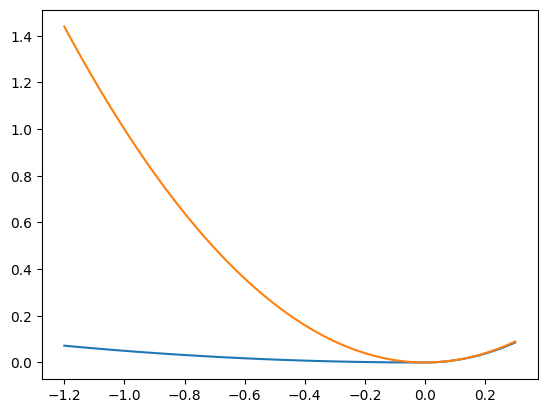

In [40]:
x = np.linspace(-1.2, .3, 100)

def expectile(x, tau):
    y = np.zeros_like(x)
    pos_x_map = x > 0
    y[pos_x_map] = tau * x[pos_x_map]**2
    y[~pos_x_map] = (1-tau) * x[~pos_x_map]**2
    return y

y = expectile(x, tau=0.95)
plt.plot(x, y)
plt.plot(x, x**2)
plt.show()

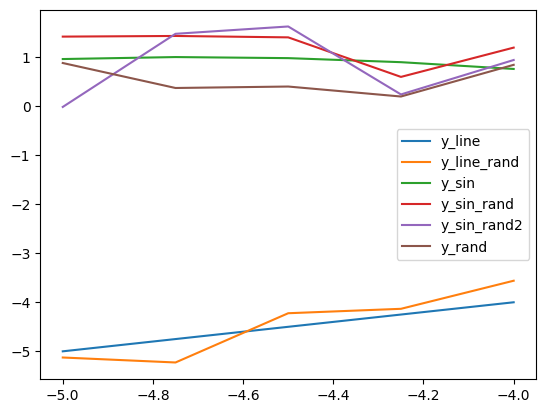

In [33]:
x = np.linspace(-5, -4, 5)

ys = {
    "y_line": x,
    "y_line_rand": x + (np.random.random(*x.shape) - .5),
    "y_sin": np.sin(x),
    "y_sin_rand": np.sin(x) + (np.random.random(*x.shape) - .5),
    "y_sin_rand2": np.sin(x) + 2 * (np.random.random(*x.shape) - .5),
    "y_rand": np.random.random(*x.shape),
}

for k, v in ys.items():
    plt.plot(x, v, label=k)
plt.legend()

In [55]:
ts = pd.Series([1.,1.,1.,1.,0.2])
r = ts.autocorr(lag=1)

/opt/homebrew/anaconda3/envs/rlboost/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/homebrew/anaconda3/envs/rlboost/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [59]:
np.isnan(r)

True

In [36]:
from scipy.signal import find_peaks
from scipy.fftpack import fft

results = {}
for k, v in ys.items():
    ts = pd.Series(v)
    
    # Autocorrelation
    autocorr = np.correlate(v - np.mean(v), v - np.mean(v), mode='full')
    autocorr = autocorr[autocorr.size // 2:]
    autocorr_at_lag1 = autocorr[1] / autocorr[0]
    
    # Roughness Index
    roughness_index = np.sum(np.abs(np.diff(v)))
    
    results[k] = {
        "autocorr": ts.autocorr(lag=1),
        "autocorr2": autocorr_at_lag1,
        "roughness_index": roughness_index,
    }

In [37]:
df = pd.DataFrame(results).T
df

,autocorr,autocorr2,roughness_index
y_line,1.000000,0.400000,1.000000
y_line_rand,0.707862,0.350202,1.768156
y_sin,0.825777,0.275518,0.282859
y_sin_rand,-0.040075,-0.039349,1.444969
y_sin_rand2,-0.360588,-0.277180,3.728187
y_rand,-0.484874,-0.244212,1.388384


In order to detect if proposed actions are smooth, the agent needs to have past actions in its observation space. Otherwise it can't optimize for that.
For reference, see [this run](https://wandb.ai/kilian/DRL-Traj-Planner/runs/ey6a9fzv?nw=nwuserkilian) which uses past actions in its observation space vs [this run](https://wandb.ai/kilian/DRL-Traj-Planner/runs/yz9ixg7v?nw=nwuserkilian) which doesn't. THe latter fails to optimize smoothness (i.e. angular auto correlation which really is the total variation over the last 5 actions.

# Normalized reward terms

In [5]:
def r_aug(action):
    return 1 - (np.abs(action).mean() * 2)

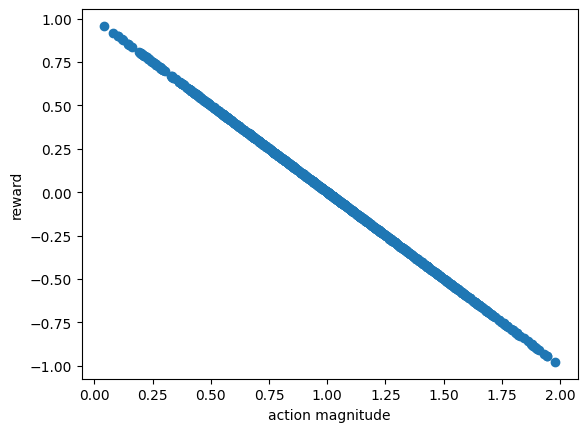

In [70]:
action = np.random.rand(1000, 2) * 2 - 1
plt.scatter(np.abs(action).sum(axis=1), [r_aug(a) for a in action])
plt.xlabel('action magnitude')
plt.ylabel('reward')
plt.show()

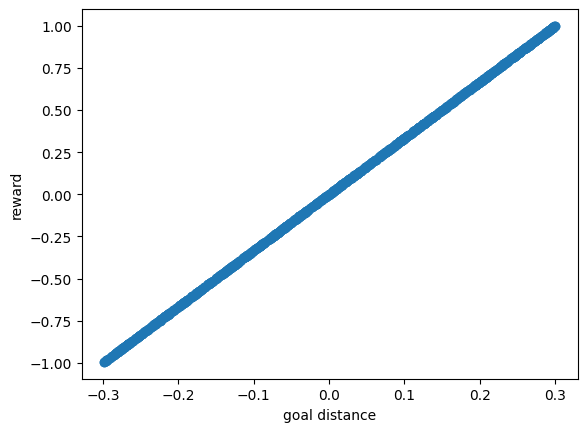

In [71]:
max_v = 1.5
dt = 0.2

def r_goal_dist(goal_dist_diff):
    return goal_dist_diff / (max_v * dt)
    
goal_dist_diff = (np.random.rand(1000) * 2 - 1) * max_v * dt
plt.scatter(goal_dist_diff, [r_goal_dist(d) for d in goal_dist_diff])
plt.xlabel('goal distance')
plt.ylabel('reward')
plt.show()

0.0854999999999999


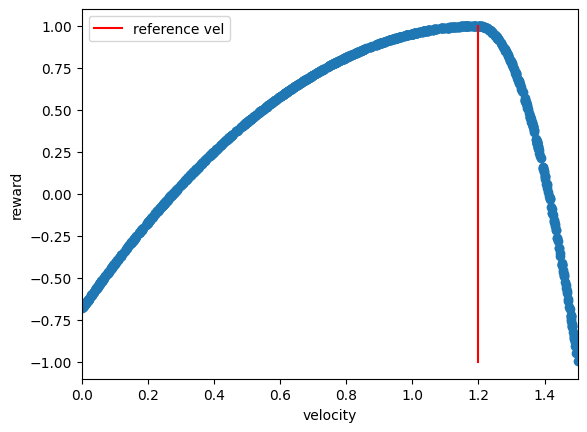

In [80]:
tau = 0.95
v_ref = 0.8 * max_v
max_value = max(expectile(np.array(-v_ref), tau), expectile(np.array(max_v - v_ref), tau))

print(max_value)

def r_speed(vel):
    v_err = vel - v_ref
    return 1 - ((expectile(v_err, tau) * 2) / max_value)
    
vs = np.random.rand(1000) * max_v
plt.scatter(vs, [r_speed(v) for v in vs])
plt.plot([v_ref, v_ref], [-1, 1], c='red', label='reference vel')
plt.xlim(0, max_v)
plt.xlabel('velocity')
plt.ylabel('reward')
plt.legend()
plt.show()

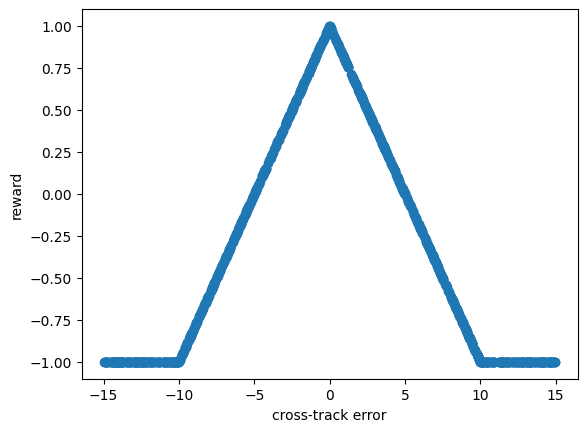

In [85]:
max_error = 10.

def r_cross_track(ct_err):
    reward = 1 - (2 * np.abs(ct_err) / max_error)
    reward = np.clip(reward, -1, 1)
    return reward
    
ct_errs = (np.random.rand(1000) * 2 - 1) * 15
plt.scatter(ct_errs, [r_cross_track(e) for e in ct_errs])
plt.xlabel('cross-track error')
plt.ylabel('reward')
plt.show()